# Historical and future simulation of hailstorms in Australia

In [1]:
%cd git/hist_future_hail/

/home/561/tr2908/git/hist_future_hail


In [2]:
import sys
import xarray
import numpy as np
import seaborn as sns
import cartopy.crs as ccrs
from importlib import reload
import matplotlib.pyplot as plt
import modules.hist_fut_hail as hf
from dask.distributed import Client

## Settings

In [3]:
base_dir = '/g/data/up6/tr2908/hist_future_hail/'   # Data base directory.
hist_years = np.arange(1989,2009)                   # Historical years.
fut_years = np.arange(2080,2100)                    # Future years.
wrf_template_dir = f'{base_dir}/WRF_v4.4/template/' # Template directory for WRF/WPS setups.
sims_dir = f'{base_dir}/WRF_v4.4/simulations'       # Simulation directory.
data_dir = f'{base_dir}/xu_data'                    # Xu et al. data directory.

In [4]:
client = Client()

## Setup

### Domain

This code lets us experiment with domain setups in a fast way to get the nesting structure correct and domains in the right places.

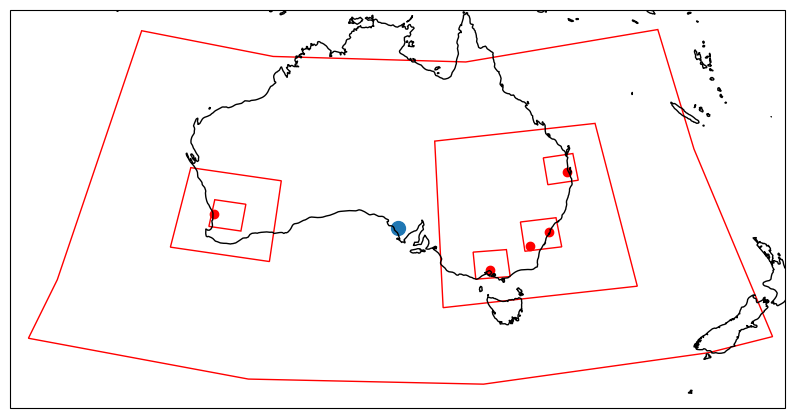

parent_id = 1, 1, 2, 1, 4, 4, 4,
i_parent_start = 1, 34, 34, 126, 34, 123, 87,
j_parent_start = 1, 51, 34, 34, 34, 144, 64,
e_we = 223, 103, 103, 190, 103, 103, 115,
e_sn = 136, 103, 103, 211, 103, 103, 112,
dx = 0.25
dy = 0.25
ref_lat = -33.4
ref_lon = 135.2
pole_lat = 56.6
pole_lon = 0
stand_lon = 44.8


In [5]:
#                                       outer, west, perth, east, melb, bris, cbr-syd,
hf.plot_wrf_domain_def(parent_id      = [    1,    1,     2,    1,    4,    4,      4],
                       i_parent_start = [    1,   34,    34,  126,   34,  123,     87],
                       j_parent_start = [    1,   51,    34,   34,   34,  144,     64],
                       e_we           = [  223,  103,   103,  190,  103,  103,    115],
                       e_sn           = [  136,  103,   103,  211,  103,  103,    112],
                       dx=0.25,
                       dy=0.25,
                       ref_lat=-33.4, 
                       ref_lon=135.2,
                       num_doms=7,
                       scale_factor=3,
                       pts=hf.cities)

Now, after namelist.wps has been updated and geogrid.exe has been run, we can plot the real domains, which should be close to the estimated version above:

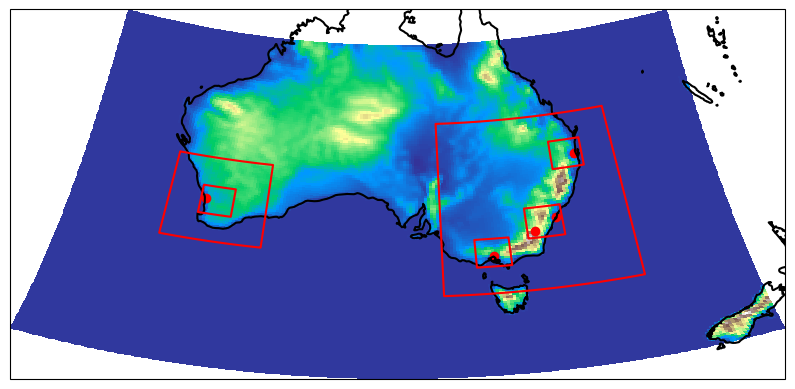

In [6]:
hf.plot_wrf_domains(wps_dir=f'{base_dir}/WRF_v4.4/simulations/hist/1989-1990/WPS', pts=hf.cities)

In [7]:
hail_clim = xarray.open_dataset('data/hail_proxy_climatology_1979-2021.nc')

### Input data

WRF boundary conditions are supplied from [Xu et al., 2021](https://www.nature.com/articles/s41597-021-01079-3) (data are CC-BY-4.0):

- Publication: https://www.nature.com/articles/s41597-021-01079-3
- Data archive: https://www.scidb.cn/en/detail?dataSetId=791587189614968832

The following code generates scripts that can be run to download all the boundary condition data. Note that the land conditions need to be downloaded and unzipped. The land conditions are in single files available from the data archive link above.

In [8]:
# hf.gen_download_script(years=hist_years, out_file=f'{base_dir}/xu_data/hist/download_hist.sh')
# hf.gen_download_script(years=fut_years, out_file=f'{base_dir}/xu_data/ssp245/download_ssp245_full.sh', fut_ssp='ssp245')

### WRF setup

The following code sets up the directories and WRF files for each run.

In [9]:
#for year in hist_years:
#    hf.set_up_WRF(year=year, template_dir=wrf_template_dir, sims_dir=sims_dir+'/hist/', exp='hist')
#for year in fut_years:
#    hf.set_up_WRF(year=year, template_dir=wrf_template_dir, sims_dir=sims_dir+'/ssp245/', exp='ssp245')

To run WPS and WRF, e.g. for the historical runs:
    
```
cd /g/data/up6/tr2908/hist_future_hail/WRF_v4.4/simulations/hist
for i in *; do cd $i/WPS/; qsub ~/git/hist_future_hail/scripts/run_WPS.sh; cd ../../; done
for i in *; do cd $i/WRF/; qsub ~/git/hist_future_hail/scripts/run_real.sh; cd ../../; done
for i in *; do cd $i/WRF/; qsub ~/git/hist_future_hail/scripts/run_WRF.sh; cd ../../; done
```

Then to restart WRF, set up the restart runs:

```
for i in */WRF/; do cd $i; echo $i; bash ~/git/hist_future_hail/scripts/restart_WRF.sh; cd ../../; done
```

then run WRF again:

```
for i in *; do cd $i/WRF/; qsub ~/git/hist_future_hail/scripts/run_WRF.sh; cd ../../; done
```

Note that the following temporary files have been removed post-run to save space, but could be generated again using the above scripts:

* `WPS/met_em*.nc`

## WRF settings

By default the runs used a 100 s timestep. Some runs failed due to CFL errors (which with the selected microphysics scheme simply hang at a given timestep). For these runs, I performed a restart and ran that day only with a reduced timestep, then resumed the run with 100 s timesteps afterwards. The days run with a reduced time step were the following:

Historical:
```
1990-01-23 (60 s)
1990-01-24 (80 s)
1991-02-06 (80 s)
1991-11-18 (80 s)
1994-01-01 (80 s)
1994-02-09 (80 s)
1995-02-06 (80 s)
1995-12-18 (80 s)
1995-12-21 (80 s)
1997-02-03 (80 s)
1997-02-06 (80 s)
1997-02-20 (80 s)
1998-01-17 (80 s)
1998-11-07 (80 s)
1998-12-23 (80 s)
1998-12-24 (60 s)
1999-12-24 (80 s)
2001-02-12 (80 s)
2002-01-09 (80 s)
2002-01-27 (80 s)
2002-11-18 (80 s)
2003-01-16 (80 s)
2007-12-31 (80 s)
2008-01-02 (80 s)
```

SSP2-4.5:
```
2080-11-14 (80 s)
2081-02-06 (80 s)
2084-11-23 (80 s)
2085-01-03 (80 s)
2086-01-28 (80 s)
2086-11-10 (80 s)
2087-02-14 (60 s)
2087-02-18 (80 s)
2087-12-25 (80 s)
2088-01-22 (80 s)
2088-01-30 (80 s)
2088-12-30 (80 s)
2089-01-12 (80 s)
2089-01-17 (80 s)
2090-12-04 (60 s)
2091-01-31 (80 s)
2091-02-13 (80 s)
2091-12-18 (80 s)
2092-01-31 (80 s)
2092-02-23 (60 s)
2092-11-03 (80 s)
2092-11-05 (80 s)
2092-11-19 (80 s)
2092-11-20 (60 s)
2094-01-13 (80 s)
2094-01-16 (80 s)
2094-10-25 (80 s)
2095-01-10 (80 s)
2095-01-12 (80 s)
2095-01-16 (80 s)
2095-01-17 (80 s)
2095-01-18 (80 s)
2095-01-24 (80 s)
2095-01-28 (80 s)
2095-12-23 (80 s)
2096-01-20 (60 s)
2096-01-22 (80 s)
2096-10-22 (80 s)
2096-12-19 (80 s)
2096-12-20 (80 s)
2097-02-03 (80 s)
2098-01-16 (80 s)
2099-12-07 (80 s)
2100-01-20 (60 s)
2100-02-07 (80 s)
2100-02-08 (60 s)
2100-02-09 (60 s)
```

## Temperature increases by year

We use a temperature-based framework to talk about future changes. To get mean near-surface air temperature we use the weighted mean (weighted by cosine of latitude) in the Xu et al SSP2-4.5 dataset. The following code can be used to generate this dataset after the lnd file for ssp245 has been wget and unzipped into /scratch.

In [10]:
# hf.mean_temp_per_year(infiles={'SSP2-4.5': '/scratch/w42/tr2908/xu_data/lnd.ssp245.*.nc',
#                                'SSP5-8.5': '/scratch/w42/tr2908/xu_data/lnd.ssp585.*.nc'},
#                       outfile=f'{data_dir}/mean_temperature_by_year.nc')

In [11]:
mean_temps = xarray.open_dataset(f'{data_dir}/mean_temperature_by_year.nc')

The reference temperature of 13.6 C is the mean temperature 1850-1900, annual using [CMIP6 35-model ensemble](https://interactive-atlas.ipcc.ch/permalink/Gzfztqvg).

In [12]:
reference_temp = (13.6 + 273.15) # Mean temperature 1850-1990 using CMIP6 ensemble, annual, 35 models (https://interactive-atlas.ipcc.ch/regional-information#eyJ0eXBlIjoiQVRMQVMiLCJjb21tb25zIjp7ImxhdCI6MTc0MTAxMCwibG5nIjotNTU4MzgyNSwiem9vbSI6MywicHJvaiI6IkVQU0c6NTQwMzAiLCJtb2RlIjoiY29tcGxldGVfYXRsYXMifSwicHJpbWFyeSI6eyJzY2VuYXJpbyI6Imhpc3RvcmljYWwiLCJwZXJpb2QiOiJwcmVJbmR1c3RyaWFsIiwic2Vhc29uIjoieWVhciIsImRhdGFzZXQiOiJIQ01JUDYiLCJ2YXJpYWJsZSI6InRhcyIsInZhbHVlVHlwZSI6IlZBTFVFIiwiaGF0Y2hpbmciOiJTSU1QTEUiLCJyZWdpb25TZXQiOiJhcjYiLCJiYXNlbGluZSI6InByZUluZHVzdHJpYWwiLCJyZWdpb25zU2VsZWN0ZWQiOls0NywxLDMsNCw1LDIsMCw1MCw4LDcsNiw0NiwyOCwxNiwxNywxOCwxOSwzMiwyOSwzMCwzNCwzMywzNSwzMSwyMCwyMSwzNiwyMiw1MSwxMSwxMCw5LDQ4LDQ5LDEzLDE0LDI1LDI2LDI0LDUzLDM3LDU0LDM4LDM5LDQwLDQxLDQyLDU3LDEyLDUyLDIzLDU1LDI3LDU2LDQzLDE1LDQ1LDQ0XX0sInBsb3QiOnsiYWN0aXZlVGFiIjoidGFibGUiLCJzaG93aW5nIjp0cnVlLCJtYXNrIjoibm9uZSIsInNjYXR0ZXJZTWFnIjoiVkFMVUUiLCJzY2F0dGVyWVZhciI6InRhcyJ9fQ==)
mean_temps['change'] = mean_temps.tas - reference_temp
mean_temps.change.attrs = {'long_name': 'Temperature change relative to 1850-1900', 'units': 'K'}

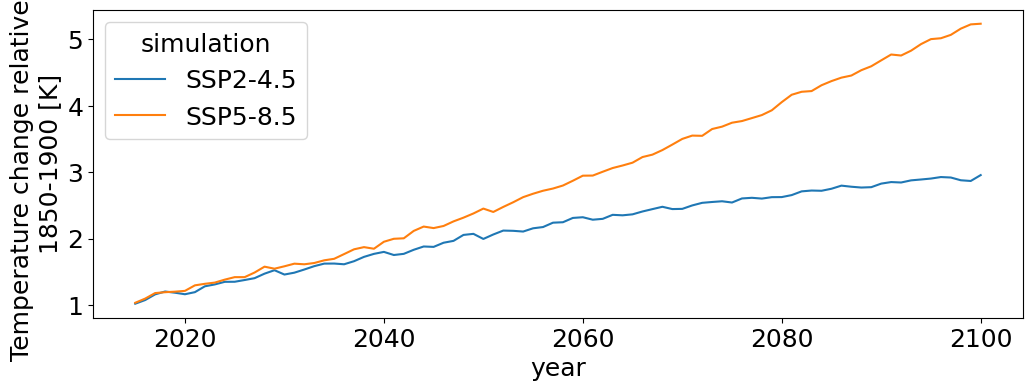

In [13]:
mean_temps.change.plot(figsize=(12,4), hue='simulation')
plt.show()

In [14]:
mean_temps = mean_temps.sel(simulation='SSP2-4.5')
cross_2 = mean_temps.where(mean_temps.change > 2, drop=True).year.min().values
cross_25 = mean_temps.where(mean_temps.change > 2.5, drop=True).year.min().values
mean_change_fut_years = mean_temps.sel(year=slice(fut_years.min(), fut_years.max()+1)).change.mean().values
print(f'Mean temperature change over the future years selected here ({fut_years.min()}-{fut_years.max()+1}) is {np.round(mean_change_fut_years, 2)} K over pre-industrial.')
print(f'Mean temperature crosses 2 degrees over pre-industrial in {cross_2} (window is {cross_2-10}-{cross_2+10}).')
print(f'Mean temperature crosses 2.5 degrees over pre-industrial in {cross_25} (window is {cross_25-10}-{cross_25+10}).')

Mean temperature change over the future years selected here (2080-2100) is 2.81 K over pre-industrial.
Mean temperature crosses 2 degrees over pre-industrial in 2048 (window is 2038-2058).
Mean temperature crosses 2.5 degrees over pre-industrial in 2071 (window is 2061-2081).


## Read hourly statistics

In [22]:
hist = xarray.open_mfdataset('/g/data/up6/tr2908/hist_future_hail/WRF_v4.4/simulations/hist/*/WRF/basic*d07*.nc', parallel=True)
futu = xarray.open_mfdataset('/g/data/up6/tr2908/hist_future_hail/WRF_v4.4/simulations/ssp245/*/WRF/basic*d07*.nc', parallel=True)

In [30]:
hist_maxhail = hist.hailcast_diam_max.max('time').load()
futu_maxhail = futu.hailcast_diam_max.max('time').load()

In [80]:
hist_maxhail = hist_maxhail.assign_coords({'south_north': hist.latitude.isel(time=0).mean('west_east'),
                                           'west_east': hist.longitude.isel(time=0).mean('south_north')})
futu_maxhail = futu_maxhail.assign_coords({'south_north': hist.latitude.isel(time=0).mean('west_east'),
                                           'west_east': hist.longitude.isel(time=0).mean('south_north')})

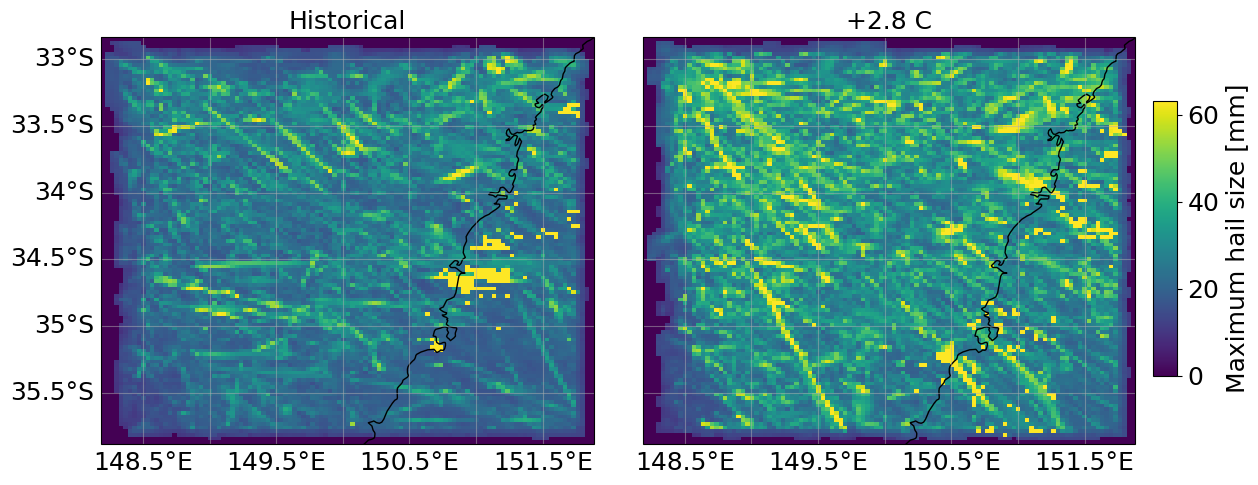

In [85]:
_ = hf.plot_map([hist_maxhail, futu_maxhail], ncols=2, share_axes=True, coastlines=True, grid=True, figsize=(12,5), 
                colour_scale=[0,75], wspace=0.1, share_scale=True, scale_label='Maximum hail size [mm]',            
                shared_scale_quantiles=[0,.98], file='syd_canb_com.pdf', 
                title=['Historical', '+2.8 C'])

In [17]:
%%time
stats = hf.conv_stats()

Historical Perth
SSP2-4.5 Perth
Historical Melbourne
SSP2-4.5 Melbourne
Historical Brisbane
SSP2-4.5 Brisbane
Historical Sydney + Canberra
SSP2-4.5 Sydney + Canberra
CPU times: user 9.25 s, sys: 3.23 s, total: 12.5 s
Wall time: 13.7 s


In [18]:
stats

<xarray.Dataset> Size: 486MB
Dimensions:                          (city: 4, time: 145680, quantile: 5,
                                      south_north: 111, west_east: 111, sim: 2)
Coordinates:
  * city                             (city) object 32B 'Brisbane' ... 'Sydney...
  * time                             (time) datetime64[ns] 1MB 1989-09-30 ......
  * quantile                         (quantile) float64 40B 0.0 0.05 ... 1.0
  * south_north                      (south_north) int64 888B 0 1 2 ... 109 110
  * west_east                        (west_east) int64 888B 0 1 2 ... 109 110
  * sim                              (sim) <U10 80B 'Historical' '+2.8 C'
Data variables: (12/20)
    hailcast_diam_max_mean           (city, sim, time) float32 5MB nan ... nan
    mixed_100_cape_mean              (city, sim, time) float64 9MB 0.0 ... 2.245
    mixed_100_cin_mean               (city, sim, time) float64 9MB 0.0 ... -1...
    mixed_100_lifted_index_mean      (city, sim, time) float64 9MB 9.493 ... ...
    lapse_rate_700_500_mean          (city, sim, time) float32 5MB -5.26 ... ...
    temp_500_mean                    (city, sim, time) float32 5MB 264.4 ... ...
    ...                               ...
    temp_500_quantile                (city, sim, quantile, time) float64 47MB ...
    freezing_level_quantile          (city, sim, quantile, time) float64 47MB ...
    melting_level_quantile           (city, sim, quantile, time) float64 47MB ...
    shear_magnitude_quantile         (city, sim, quantile, time) float64 47MB ...
    latitude                         (city, south_north, west_east) float32 197kB ...
    longitude                        (city, south_north, west_east) float32 197kB ...

In [86]:
from shapely.geometry import Polygon
from geopandas import gpd

polygons = []
for city in stats.city.values:
    lats = stats.sel(city=city).latitude.values
    lons = stats.sel(city=city).longitude.values
    bbox = Polygon([(np.nanmin(lons), np.nanmin(lats)),
                    (np.nanmax(lons), np.nanmin(lats)),
                    (np.nanmax(lons), np.nanmax(lats)),
                    (np.nanmin(lons), np.nanmax(lats))])
    polygons.append(bbox)
polygons = gpd.GeoSeries(polygons).boundary

In [87]:
plt.show()                                                              # Start the plotting engine.
plt.rcParams['font.size'] = 12                                          # Font size for plots.
plt.rcParams['axes.formatter.useoffset'] = False                        # Don't use offsets in plots.

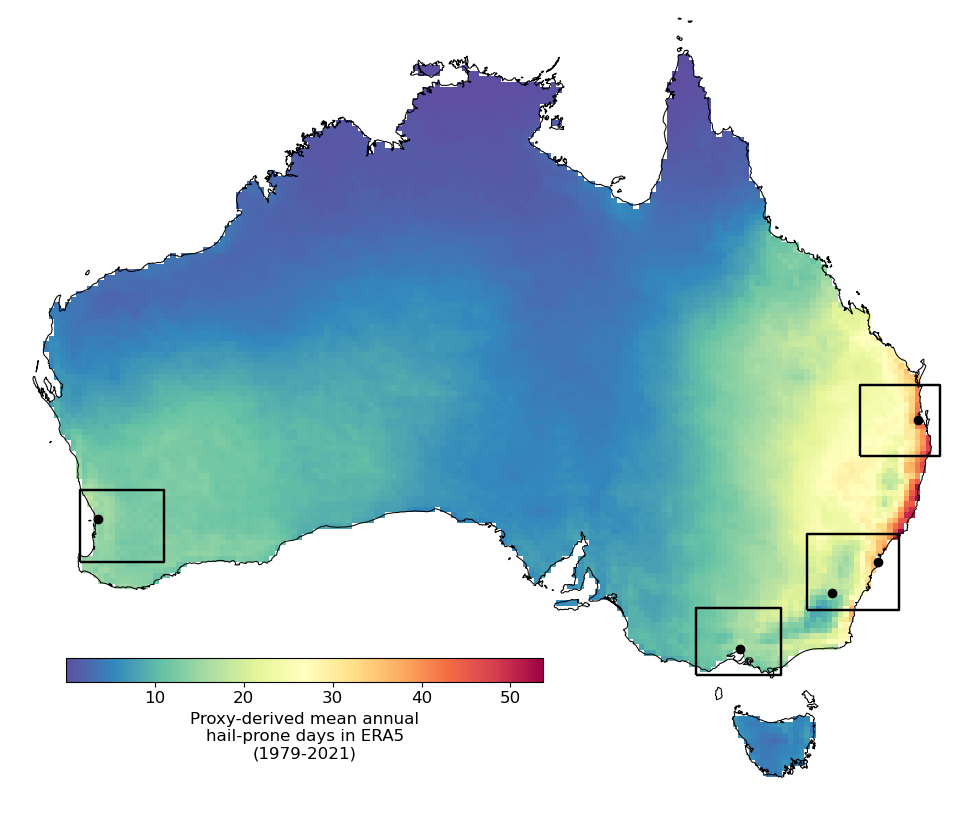

<GeoAxes: xlabel='longitude [degrees_east]', ylabel='latitude [degrees_north]'>

In [88]:
hail_clim.hail_proxy.attrs['long_name'] = 'Proxy-derived mean annual hail-prone days in ERA5 (1979-2021)'
hf.plot_map(hail_clim.hail_proxy, cmap='Spectral_r', country='Australia', title='', 
            cbar_shrink=0.4, cbar_pad=0.015, axis_off=True, figsize=(12,8),
            cbar_inset=True, cbar_orientation='horizontal', nan_colour='white', pts=hf.cities,
            grid=False, polygons=polygons, polygon_colour='black', file='climatology_and_domains.pdf')

In [89]:
import scipy.stats as scs

In [113]:
def plot_dist_comparison(dat, variables, varnames, maskvar=None, mask=None, quantiles=None,
                         figsize=(12,6), xlims=None, log=None, file=None, invert=False, 
                         palettes=None, hspace=0.7, wspace=0.5, showfliers=False):
    """
    Plot a distribution comparison between simulations.

    Arguments:
        dat: Data to use for the plots.
        variables: The variables to plot for (one row per variable).
        quantiles: If required, the quantile to select.
        varnames: Pretty-print name of variables for axis labels.
        figsize: Figure width, height.
        xlims: Limit x axis extent?
        log: X axis in log scale?
        invert: Invert the plot row/columns?
        palettes: Palette for each variable?
        hspace, wspace: grid spec spacings.
        showfliers: Show outliers in plots?
    """

    fig, axs = plt.subplots(ncols=len(dat.city.values), nrows=len(variables), figsize=figsize, gridspec_kw={'hspace': hspace,
                                                                                                            'wspace': wspace})
    
    for v, var in enumerate(variables):
        for i, city in enumerate(dat.city.values):

            ax = axs[v, i]
            if invert:
                ax = axs[i, v]
            
            if quantiles[v] is not None:
                d = dat.sel(city=city, quantile=quantiles[v])[variables[v]]
            else:
                d = dat.sel(city=city)[variables[v]]
                assert not 'quantile' in d.dims, 'Quantile needs to be specified for this variable.'

            hist = d.sel(sim='Historical').values
            fut = d.sel(sim='+2.8 C').values
            ttest_res, pval = scs.ttest_ind(hist[~np.isnan(hist)], 
                                            fut[~np.isnan(fut)], equal_var=False)
            sig = pval < 0.05
            print(f'{city} {var} - sig diff? {sig}')
            
            if maskvar is not None:
                if mask[v] == True:
                    m = dat.sel(city=city)[maskvar]
                    d = d.where(m > 0)

            palette = None
            if palettes is not None:
                palette = palettes[v]
            
            sns.boxplot(data=d.to_dataframe(), x=variables[v], hue='sim', fill='sim', 
                        y='sim', ax=ax, showfliers=showfliers, palette=palette, showmeans=True,
                        meanprops={'marker': 'o',
                                   'markerfacecolor': 'white', 
                                   'markeredgecolor': 'black',
                                   'markersize': 10})

            if v == 0 or invert:
                ax.set_title(city)

            if (not invert) or (i == len(dat.city.values)-1):
                ax.set_xlabel(varnames[v])
            else:
                ax.set_xlabel('')

            if not xlims is None:
                ax.set_xlim(xlims[v])

            if not log is None:
                if log[v]:
                    ax.set_xscale('log')

            if invert and v != 0:
                ax.set_yticks([])

            ax.set_ylabel('')
    
    if not file is None:
        plt.savefig(fname=file, bbox_inches='tight')
        plt.show()
        plt.close()
    else:
        plt.show()

In [93]:
d = stats.hailcast_diam_max_mean.resample(time='1D').max()
d = d.where(np.isnan(d), other=1)
d = d.resample(time='1YE').sum()
d = d.where(d > 0)
d = d.rename({'time': 'year'})
stats['hail_occurrences'] = d.load()

In [142]:
a = stats.sel(quantile=1, city='Brisbane').mixed_100_cape_quantile.isel(sim=0).dropna('time')
b = stats.sel(quantile=1, city='Brisbane').mixed_100_cape_quantile.isel(sim=1).dropna('time')

In [108]:
stats['quantile'].values

array([0.  , 0.05, 0.5 , 0.95, 1.  ])

Brisbane hailcast_diam_max_quantile - sig diff? True
Melbourne hailcast_diam_max_quantile - sig diff? True
Perth hailcast_diam_max_quantile - sig diff? False
Sydney + Canberra hailcast_diam_max_quantile - sig diff? True
Brisbane hail_occurrences - sig diff? False
Melbourne hail_occurrences - sig diff? False
Perth hail_occurrences - sig diff? False
Sydney + Canberra hail_occurrences - sig diff? True


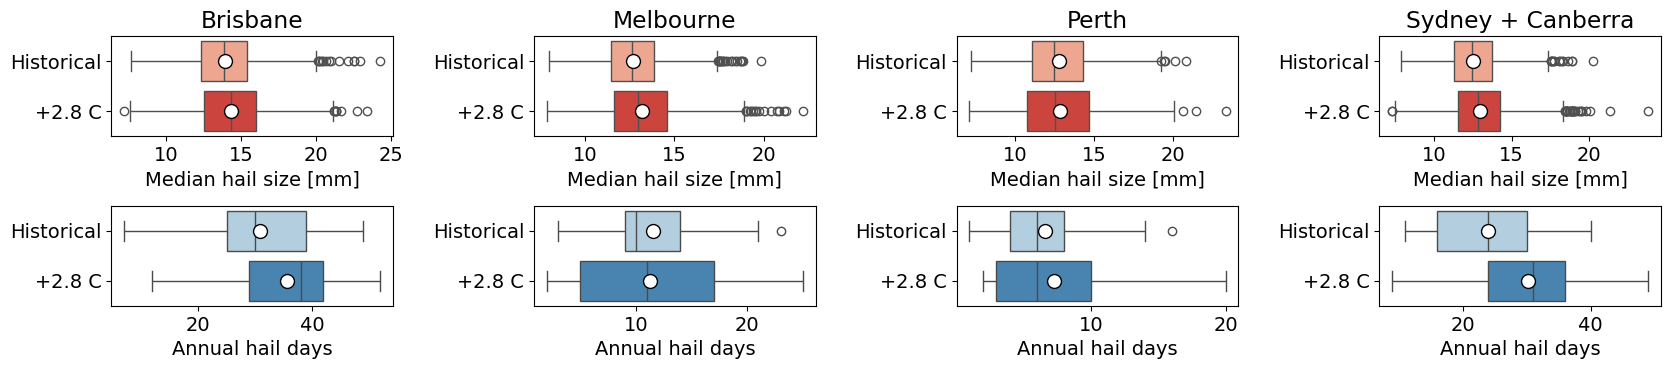

In [114]:
plt.rcParams['font.size'] = 14
plot_dist_comparison(dat=stats, 
                     variables=['hailcast_diam_max_quantile', 
                                'hail_occurrences'], 
                     varnames=['Median hail size [mm]', 
                               'Annual hail days'],
                     quantiles=[0.5, None], 
                     log=[False, False],
                     figsize=(20, 3.5),
                     file='hail_changes.pdf',
                     palettes=['Reds', 'Blues'],
                     showfliers=True)

Brisbane mixed_100_cape_quantile - sig diff? True
Melbourne mixed_100_cape_quantile - sig diff? True
Perth mixed_100_cape_quantile - sig diff? True
Sydney + Canberra mixed_100_cape_quantile - sig diff? True
Brisbane mixed_100_cin_quantile - sig diff? True
Melbourne mixed_100_cin_quantile - sig diff? True
Perth mixed_100_cin_quantile - sig diff? True
Sydney + Canberra mixed_100_cin_quantile - sig diff? True
Brisbane shear_magnitude_quantile - sig diff? True
Melbourne shear_magnitude_quantile - sig diff? True
Perth shear_magnitude_quantile - sig diff? True
Sydney + Canberra shear_magnitude_quantile - sig diff? True
Brisbane melting_level_mean - sig diff? True
Melbourne melting_level_mean - sig diff? True
Perth melting_level_mean - sig diff? True
Sydney + Canberra melting_level_mean - sig diff? True


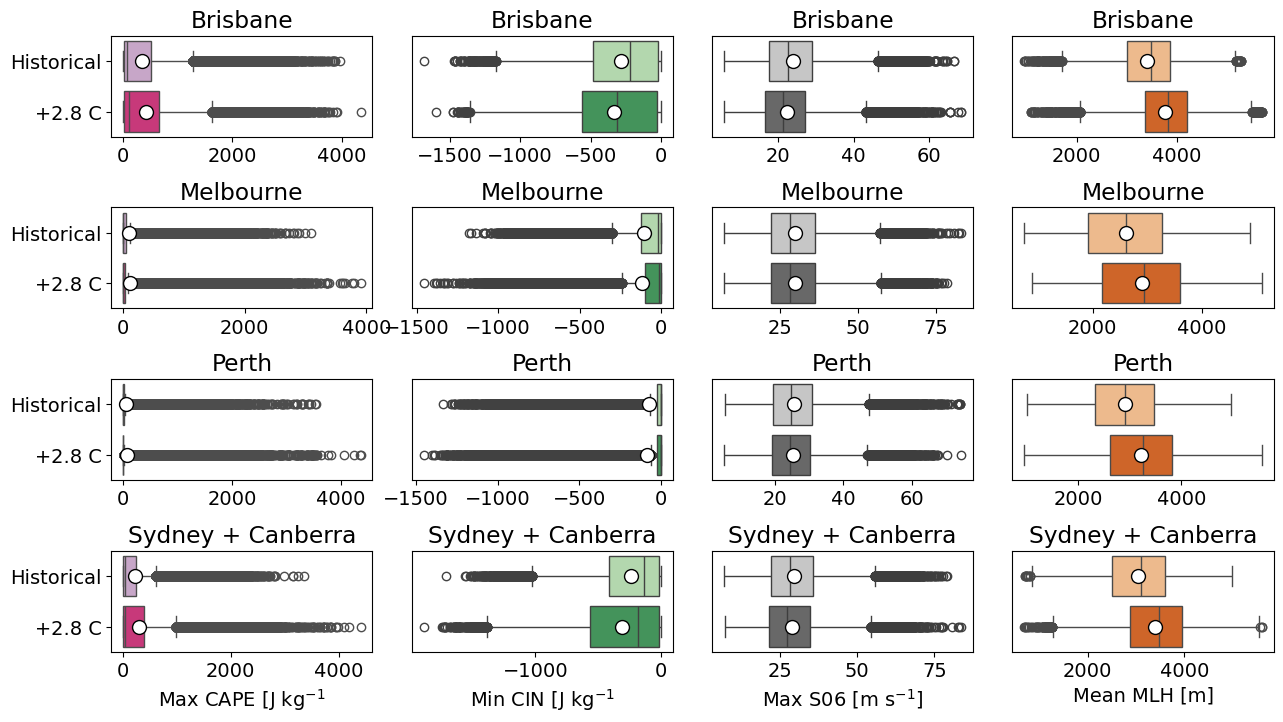

In [128]:
plot_dist_comparison(dat=stats, #maskvar='hailcast_diam_max_mean',
                     variables=['mixed_100_cape_quantile', 
                                'mixed_100_cin_quantile',
                                'shear_magnitude_quantile', 
                                'melting_level_mean'], 
                     varnames=['Max CAPE [J kg$^{-1}$', 
                               'Min CIN [J kg$^{-1}$', 
                               'Max S06 [m s$^{-1}$]', 
                               'Mean MLH [m]'],
                     #mask=[True, True, True, True],
                     quantiles=[1, 0, 1, None], 
                     log=[False, False, False, False],
                     figsize=(15, 8), invert=True,
                     palettes=['PuRd', 'Greens', 'Greys', 'Oranges'],
                     wspace=0.15, showfliers=True,
                     file='ing_changes.pdf')

**Still need to ensure that all times are sorted in order!**

In [ ]:
min_times = np.inf
for city in dat:
    for sim in dat[city]:
        if dat[city][sim].Time.size < min_times:
            min_times = dat[city][sim].Time.size
            
# Subset to the first min_times times.
for city in dat:
    for sim in dat[city]:
        dat[city][sim] = dat[city][sim].isel(Time=slice(0, min_times))

In [ ]:
dat.keys()

In [ ]:
max_hail = []
#for city in dat:
for sim in dat['Brisbnane']:
    max_hail.append(dat['Brisbnane'][sim].HAILCAST_DIAM_MAX.max(['south_north', 'west_east']))

In [ ]:
max_hail = xarray.combine_nested(max_hail, concat_dim='simulation')

In [ ]:
print(max_hail.where(max_hail > 20).isel(simulation=0).count().values)
print(max_hail.where(max_hail > 20).isel(simulation=0).mean().values)

In [ ]:
print(max_hail.where(max_hail > 20).isel(simulation=1).count().values)
print(max_hail.where(max_hail > 20).isel(simulation=1).mean().values)

In [ ]:
d = f'{base_dir}/WRF_v4.4/simulations/hist/1989-1990/WRF'
print(d)

In [ ]:
perth = xarray.open_mfdataset(f'{d}/wrfout_d03_*', parallel=True, combine='nested', concat_dim='Time')
melb = xarray.open_mfdataset(f'{d}/wrfout_d05_*', parallel=True, combine='nested', concat_dim='Time')
bris = xarray.open_mfdataset(f'{d}/wrfout_d06_*', parallel=True, combine='nested', concat_dim='Time')
cbr_syd = xarray.open_mfdataset(f'{d}/wrfout_d07_*', parallel=True, combine='nested', concat_dim='Time')

In [ ]:
perth

In [ ]:
def plot_time(doms, titles=None, t=3, f='', pts=None, nrow=1, ncol=4, figsize=(12,4)):
    assert ncol * nrow >= len(doms), 'Insufficient rows/columns.'
    fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()}, nrows=nrow, ncols=ncol, figsize=figsize)
    
    for i, d in enumerate(doms):
        x = d.isel(Time=t).XLONG
        y = d.isel(Time=t).XLAT
        z = d.isel(Time=t)[f]

        ax.flat[i].pcolormesh(x, y, z, transform=ccrs.PlateCarree())
        ax.flat[i].coastlines(color='blue')
    
        if not titles is None:
            ax.flat[i].set_title(titles[i])
    
        # Add optional points.
        if not pts is None:
            for j in pts[i].keys():
                ax.flat[i].scatter(pts[i][j][0], pts[i][j][1], color='red')                          

In [ ]:
plot_time(doms=[perth, melb, cbr_syd, bris], 
          titles=['Perth', 'Melbourne', 'Canberra + Sydney', 'Brisbane'],
          f='TSK',
          pts=[{x: hf.cities[x] for x in ['Perth']},
               {x: hf.cities[x] for x in ['Melbourne']},
               {x: hf.cities[x] for x in ['Canberra', 'Sydney']},
               {x: hf.cities[x] for x in ['Brisbane']}])

In [ ]:
perth.isel(Time=0)